<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/Code_Figure3_b%2C_d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seoul data analysis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ============================================
# Cell 1 — Load populations and plot histograms (counts + normalized)
# Files:
#   - population_Seoul_426dong_2023.xlsx  (Sheet1)
# Columns:
#   dong_cd, household, regist_pop, defacto_pop
# Notes:
#   - We'll mainly use 'defacto_pop' downstream.
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------- Config -----------
data_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"  # change if your files are elsewhere
pop_file = os.path.join(data_dir, "population_Seoul_426dong_2023.xlsx")
pop_sheet = "Sheet1"

# Matplotlib defaults
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ----------- Load -----------
df_pop = pd.read_excel(pop_file, sheet_name=pop_sheet, engine="openpyxl")

# Standardize column names and types
df_pop = df_pop.rename(columns={
    "dong_cd": "dong_cd",
    "household": "household",
    "regist_pop": "regist_pop",
    "defacto_pop": "defacto_pop"
})
# Ensure IDs are strings (important for merges)
df_pop["dong_cd"] = df_pop["dong_cd"].astype(str)

# Basic sanity checks
assert {"dong_cd", "household", "regist_pop", "defacto_pop"}.issubset(df_pop.columns)
n_dong = df_pop["dong_cd"].nunique()
print(f"[Cell 1] Loaded populations for {n_dong} dongs.")

# ----------- Totals (requested) -----------
tot_households = float(df_pop["household"].sum())
tot_regist     = float(df_pop["regist_pop"].sum())
tot_defacto    = float(df_pop["defacto_pop"].sum())

print("[Cell 1] Totals:")
print(f" - Households total     : {tot_households:,.0f}")
print(f" - Registered pop total : {tot_regist:,.0f}")
print(f" - De facto pop total   : {tot_defacto:,.0f}")


[Cell 1] Loaded populations for 426 dongs.
[Cell 1] Totals:
 - Households total     : 4,463,385
 - Registered pop total : 9,668,008
 - De facto pop total   : 10,446,532


# --- dong interdistance distribution

In [6]:
# ============================================
# Cell 2 — Load distance matrices; histogram of inter-dong distances
# Files:
# - Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_zero.csv
# - Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_radius_assuming_circle.csv
# - Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_without_sameOD
#
# We will keep all three; for the histogram, we use the "radius_if_same" file
# and EXCLUDE self pairs (O != D).
# Columns: O_ADMDONG_CD, D_ADMDONG_CD, Distance
# ============================================

dist_zero_file = os.path.join(
    data_dir,
    "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_zero.csv"
)
dist_radius_file = os.path.join(
    data_dir,
    "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_radius_assuming_circle.csv"
)
dist_wo_same_file = os.path.join(
    data_dir,
    "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_without_sameOD"
)

usecols = ["O_ADMDONG_CD", "D_ADMDONG_CD", "Distance"]
dtype_ids = {"O_ADMDONG_CD": str, "D_ADMDONG_CD": str}

df_dist_zero   = pd.read_csv(dist_zero_file, usecols=usecols, dtype=dtype_ids)
df_dist_radius = pd.read_csv(dist_radius_file, usecols=usecols, dtype=dtype_ids)
# The third file may or may not have an extension; try to read flexibly
try:
    df_dist_wo_same = pd.read_csv(dist_wo_same_file, usecols=usecols, dtype=dtype_ids)
except Exception:
    # try with .csv appended
    try:
        df_dist_wo_same = pd.read_csv(dist_wo_same_file + ".csv", usecols=usecols, dtype=dtype_ids)
    except Exception as e:
        print(f"[Cell 2] Could not load without_sameOD file directly: {e}")
        df_dist_wo_same = None

print(f"[Cell 2] Loaded distance tables:")
print(f" - same=0          : {df_dist_zero.shape}")
print(f" - same=radius     : {df_dist_radius.shape}")
print(f" - without sameOD  : {None if df_dist_wo_same is None else df_dist_wo_same.shape}")

# For later use, keep a fast distance pivot/matrix with same=radius
# Build index order from population table to keep consistent ordering
dong_ids = df_pop["dong_cd"].tolist()
id_to_idx = {d: i for i, d in enumerate(dong_ids)}
n = len(dong_ids)

# Initialize full distance matrix with NaN
dist_matrix = np.full((n, n), np.nan, dtype=float)
for _, row in df_dist_radius.iterrows():
    i = id_to_idx.get(row["O_ADMDONG_CD"])
    j = id_to_idx.get(row["D_ADMDONG_CD"])
    if i is not None and j is not None:
        dist_matrix[i, j] = float(row["Distance"])


[Cell 2] Loaded distance tables:
 - same=0          : (181476, 3)
 - same=radius     : (181476, 3)
 - without sameOD  : (181050, 3)


# ----- trip distribution

[Cell 3a] Trips loaded: non-work (181476, 3), work (176385, 3)
[Cell 3a] Summary stats (CNT per O–D):
 - Non-work: N=181,476, mean=13670.3, std=99180.4
 - Work    : N= 176,385, mean=3930.53, std=16220.8


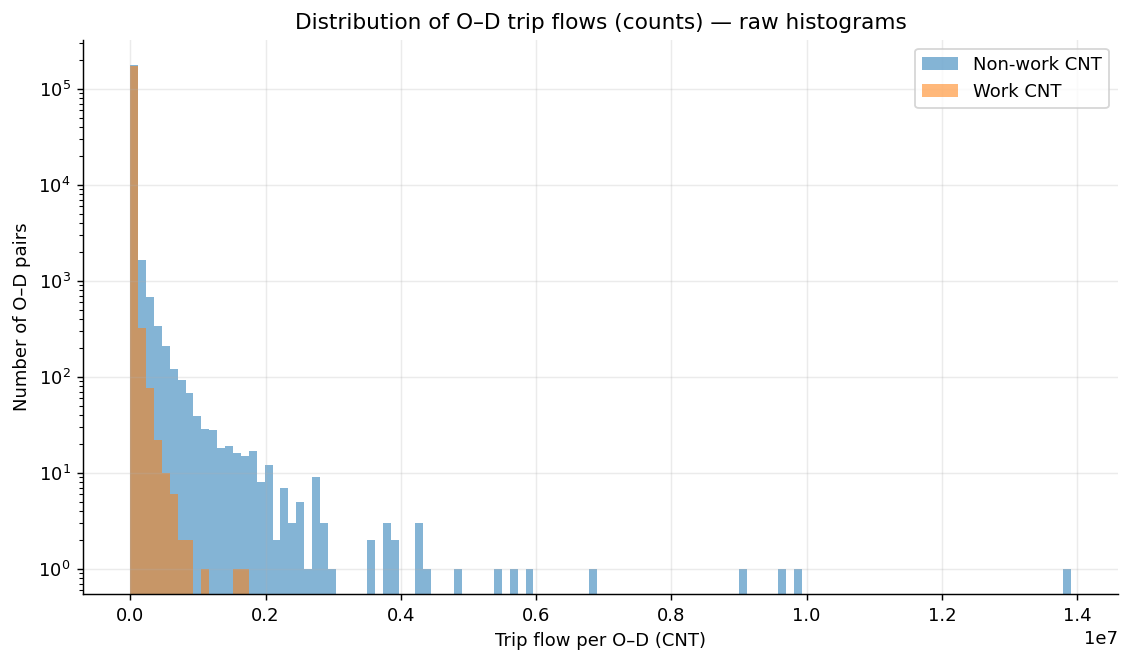

In [7]:
# ============================================
# Cell 3a — OD trip distributions (counts) with robust tail fits
# Figures:
#   (1) Raw histograms (lin–log)
#
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy import optimize

# ----- Load datasets -----
nw_file = os.path.join(data_dir, "Tij_NonworkTrips_P24567_in2023.xlsx")
w_file  = os.path.join(data_dir, "Tij_P1_Going_to_Work_in2023.xlsx")

usecols_t = ["O_ADMDONG_CD", "D_ADMDONG_CD", "CNT"]
df_T_nw = pd.read_excel(nw_file, usecols=usecols_t, engine="openpyxl")
df_T_w  = pd.read_excel(w_file , usecols=usecols_t, engine="openpyxl")

for dfT in (df_T_nw, df_T_w):
    dfT["O_ADMDONG_CD"] = dfT["O_ADMDONG_CD"].astype(str)
    dfT["D_ADMDONG_CD"] = dfT["D_ADMDONG_CD"].astype(str)
    dfT["CNT"] = pd.to_numeric(dfT["CNT"], errors="coerce").fillna(0.0)

print(f"[Cell 3a] Trips loaded: non-work {df_T_nw.shape}, work {df_T_w.shape}")

# ----- Prepare CNT arrays (finite, non-negative) -----
cnt_nw = df_T_nw["CNT"].to_numpy(float)
cnt_w  = df_T_w ["CNT"].to_numpy(float)
m_nw = np.isfinite(cnt_nw) & (cnt_nw >= 0)
m_w  = np.isfinite(cnt_w ) & (cnt_w  >= 0)
cnt_nw = cnt_nw[m_nw]
cnt_w  = cnt_w [m_w ]

# >>> NEW: summary stats before any fits <<<
N_nw = cnt_nw.size
N_w  = cnt_w.size
mean_nw = float(np.mean(cnt_nw)) if N_nw > 0 else np.nan
mean_w  = float(np.mean(cnt_w )) if N_w  > 0 else np.nan
std_nw  = float(np.std(cnt_nw, ddof=0)) if N_nw > 1 else np.nan   # population std
std_w   = float(np.std(cnt_w , ddof=0)) if N_w  > 1 else np.nan   # population std
print("[Cell 3a] Summary stats (CNT per O–D):")
print(f" - Non-work: N={N_nw:,d}, mean={mean_nw:.6g}, std={std_nw:.6g}")
print(f" - Work    : N={N_w : ,d}, mean={mean_w :.6g}, std={std_w :.6g}")

pooled = np.concatenate([cnt_nw, cnt_w])
if pooled.size == 0:
    raise ValueError("[Cell 3a] No valid CNT values to plot.")

# ----- Common bins (reuse across all figures) -----
# Freedman–Diaconis on pooled data; cap bins for stability
q75, q25 = np.nanpercentile(pooled, [75, 25])
iqr = q75 - q25
n = pooled.size
if iqr > 0 and n > 0:
    bw = 2 * iqr / (n ** (1/3))
    if bw > 0:
        nb = int(np.clip(np.ceil((pooled.max() - pooled.min()) / bw), 20, 120))
    else:
        nb = 60
else:
    nb = 60

x_min = pooled.min()
x_max = pooled.max() if pooled.max() > pooled.min() else pooled.min() + 1.0
bins = np.linspace(x_min, x_max, nb)          # EDGES
bcent = 0.5 * (bins[:-1] + bins[1:])          # centers
binw  = np.diff(bins)                          # widths

# =========================================================
# Helpers: ECDF/KS fits for Exp & PL; LS tail fit for Truncated PL
# =========================================================

def _ecdf_tail(x_tail):
    xs = np.sort(x_tail)
    n = xs.size
    y = np.arange(1, n+1, dtype=float) / n
    return xs, y

def fit_exponential_tail(x, qmin=0.70):
    """Exponential tail on x >= xmin; MLE λ=1/mean(x-xmin). xmin chosen by KS."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x >= 0)]
    if x.size < 10:
        return np.nan, np.nan, np.inf
    qs = np.linspace(qmin, 0.95, 11)
    candidates = np.quantile(x, qs)
    best = (np.inf, np.nan, np.nan)
    for xmin in candidates:
        tail = x[x >= xmin]
        if tail.size < 20:
            continue
        y_mean = (tail - xmin).mean()
        if y_mean <= 0:
            continue
        lam = 1.0 / y_mean
        xs, F_emp = _ecdf_tail(tail)
        F_mod = 1.0 - np.exp(-lam * (xs - xmin))
        ks = np.max(np.abs(F_emp - F_mod))
        if ks < best[0]:
            best = (ks, float(xmin), float(lam))
    return best[1], best[2], best[0]

def fit_powerlaw_tail(x, qmin=0.70):
    """Power-law tail on x >= xmin; MLE α = 1 + n / Σ log(x/xmin). xmin chosen by KS."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size < 10:
        return np.nan, np.nan, np.inf
    qs = np.linspace(qmin, 0.95, 11)
    candidates = np.quantile(x, qs)
    best = (np.inf, np.nan, np.nan)
    for xmin in candidates:
        tail = x[x >= xmin]
        if tail.size < 20:
            continue
        alpha = 1.0 + tail.size / np.sum(np.log(tail / xmin))
        if not np.isfinite(alpha) or alpha <= 1.0:
            continue
        xs, F_emp = _ecdf_tail(tail)
        F_mod = 1.0 - (xs / xmin) ** (1.0 - alpha)
        ks = np.max(np.abs(F_emp - F_mod))
        if ks < best[0]:
            best = (ks, float(xmin), float(alpha))
    return best[1], best[2], best[0]

def ls_truncated_powerlaw_tail_on_bins(x, bins_edges, bcent, binw, qmin=0.70):
    """
    Robust least-squares fit on tail bins for truncated power law:
        counts_k ≈ [A * x_k^{-α} * exp(-λ x_k)] * Δx_k, for centers x_k >= xmin
    xmin picked as max(best xmin from Exp/PL, 80th percentile).
    Returns xmin, A, alpha, lambda, mse, n_tailbins.
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size < 10:
        return np.nan, np.nan, np.nan, np.nan, np.inf, 0

    xmin_exp, lam_exp, _ = fit_exponential_tail(x, qmin=qmin)
    xmin_pl , alp_pl , _ = fit_powerlaw_tail(x, qmin=qmin)
    xmin_fallback = np.quantile(x, 0.80)

    xmin_cands = [v for v in [xmin_exp, xmin_pl, xmin_fallback] if np.isfinite(v)]
    xmin = float(max(xmin_cands)) if xmin_cands else np.nan
    if not np.isfinite(xmin):
        return np.nan, np.nan, np.nan, np.nan, np.inf, 0

    # Histogram COUNTS on original edges
    hist_counts, _ = np.histogram(x, bins=bins_edges)
    y_obs = hist_counts.astype(float)

    mask_tail_bins = bcent >= xmin
    if mask_tail_bins.sum() < 6:
        return xmin, np.nan, np.nan, np.nan, np.inf, mask_tail_bins.sum()

    x_tail = bcent[mask_tail_bins]
    w_tail = binw [mask_tail_bins]
    y_tail = y_obs[mask_tail_bins]

    # Model: y ≈ [A * x^{-α} * exp(-λ x)] * Δx
    def f_pdf(xv, A, alpha, lam):
        return A * np.power(xv, -alpha) * np.exp(-lam * xv)

    sigma = np.sqrt(np.clip(y_tail, 1.0, None))
    def f_fit(xv, A, alpha, lam):
        return f_pdf(xv, A, alpha, lam) * w_tail

    # Inits
    A0 = max(y_tail.max(), 1.0)
    alpha0 = alp_pl if np.isfinite(alp_pl) and alp_pl > 1 else 2.0
    lam0 = lam_exp if np.isfinite(lam_exp) and lam_exp > 0 else 1.0 / max(np.mean(x_tail), 1.0)

    try:
        popt, _ = optimize.curve_fit(
            f_fit, x_tail, y_tail, p0=[A0, alpha0, lam0],
            bounds=([0.0, 1.01, 0.0], [np.inf, 6.0, np.inf]),
            sigma=sigma, absolute_sigma=True, maxfev=20000
        )
        A_hat, alpha_hat, lam_hat = [float(v) for v in popt]
        y_hat = f_fit(x_tail, *popt)
        mse = float(np.mean((y_tail - y_hat)**2))
        return xmin, A_hat, alpha_hat, lam_hat, mse, int(mask_tail_bins.sum())
    except Exception:
        return xmin, np.nan, np.nan, np.nan, np.inf, int(mask_tail_bins.sum())

# --------- R^2 helpers (computed on tail bins) ---------
def r2_from_counts(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    sst = np.sum((y_true - y_true.mean())**2)
    sse = np.sum((y_true - y_pred)**2)
    return float(1.0 - sse / sst) if sst > 0 else np.nan

# Bin-integral expected counts for Exp and PL (more exact than center×width)
def expected_counts_exp_on_edges(bins_edges, xmin, lam, N):
    edges = np.asarray(bins_edges, float)
    left = edges[:-1]; right = edges[1:]
    a = np.maximum(left, xmin); b = np.maximum(right, xmin)
    term = (1.0 - np.exp(-lam * (b - xmin))) - (1.0 - np.exp(-lam * (a - xmin)))
    term[(right <= xmin)] = 0.0
    return N * term

def expected_counts_pl_on_edges(bins_edges, xmin, alpha, N):
    edges = np.asarray(bins_edges, float)
    left = edges[:-1]; right = edges[1:]
    a = np.maximum(left, xmin); b = np.maximum(right, xmin)
    coef = (xmin ** (alpha - 1.0))
    delta = (a ** (1.0 - alpha)) - (b ** (1.0 - alpha))
    term = (alpha - 1.0) * coef * delta
    term[(right <= xmin)] = 0.0
    return N * term

# =========================================================
# (1) Raw histogram (COUNTS, no fits) — lin–log
# =========================================================
fig1, ax1 = plt.subplots(figsize=(8.8, 5.2))
ax1.hist(cnt_nw, bins=bins, alpha=0.55, label="Non-work CNT", density=False)
ax1.hist(cnt_w , bins=bins, alpha=0.55, label="Work CNT"    , density=False)
ax1.set_yscale("log")  # lin–log
ax1.set_xlabel("Trip flow per O–D (CNT)")
ax1.set_ylabel("Number of O–D pairs")
ax1.set_title("Distribution of O–D trip flows (counts) — raw histograms")
ax1.legend()
try:
    fig1.tight_layout()
except Exception:
    pass
plt.show()

# Capture y-limits to ensure SAME on overlay plots
ymin, ymax = ax1.get_ylim()


# ----- study of SC and PE; ratio PEnw/PEw

[Cell 3b] Example rows (SC/PE):


,dong_cd,SC_nw,SC_w,PE_nw,PE_w,OT_nw,IT_nw,OT_w,IT_w,defacto_pop
0,11110530,0.154321,0.264450,0.005198,0.008677,10335822.82,12896501.83,1181525.98,6015553.54,25469
1,11110540,0.080506,0.126065,0.001307,0.000918,2604562.08,3242548.04,215030.94,636115.02,5994
2,11110550,0.190363,0.092707,0.001335,0.000700,3298781.23,3311255.99,673312.93,485608.84,14177
3,11110560,0.199397,0.097820,0.001455,0.000820,4585172.62,3609338.72,1123151.65,568389.02,17816
4,11110570,0.089620,0.054232,0.000559,0.000361,1697658.10,1387913.98,493042.30,250310.27,6693


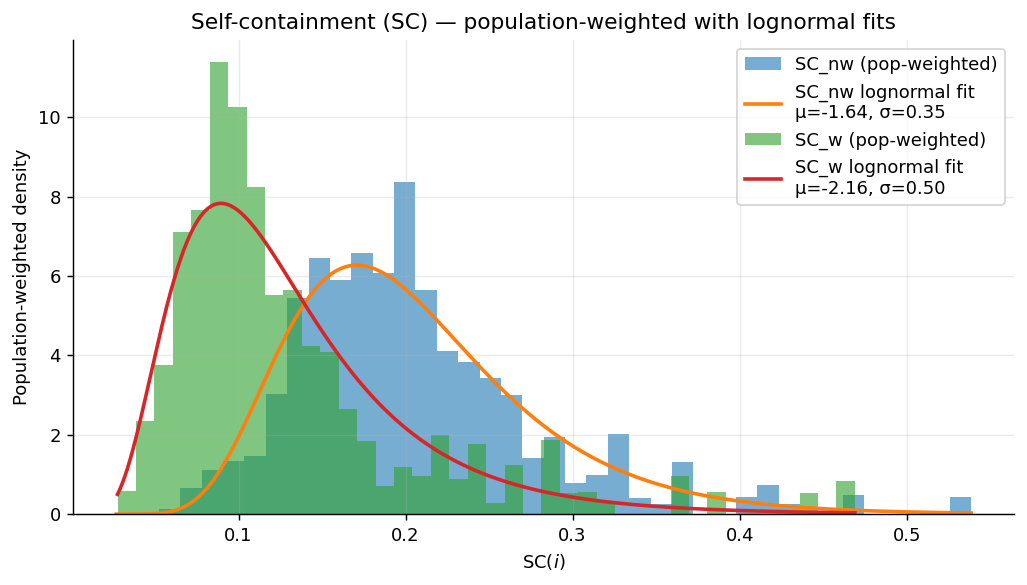

[Cell 3b][Lognormal] SC parameters:
 - SC_nw: mu_log=-1.6447, sigma_log=0.3501, mean=0.205266, std=0.074120
 - SC_w : mu_log=-2.1618, sigma_log=0.5017, mean=0.130563, std=0.069853


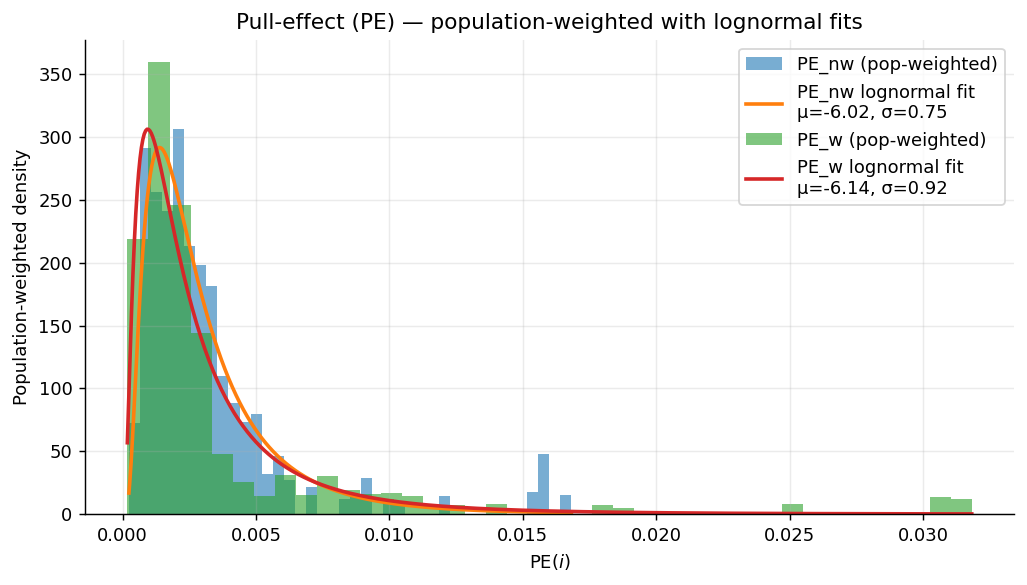

[Cell 3b][Lognormal] PE parameters:
 - PE_nw: mu_log=-6.0236, sigma_log=0.7469, mean=0.003200, std=0.002766
 - PE_w : mu_log=-6.1360, sigma_log=0.9151, mean=0.003289, std=0.003765


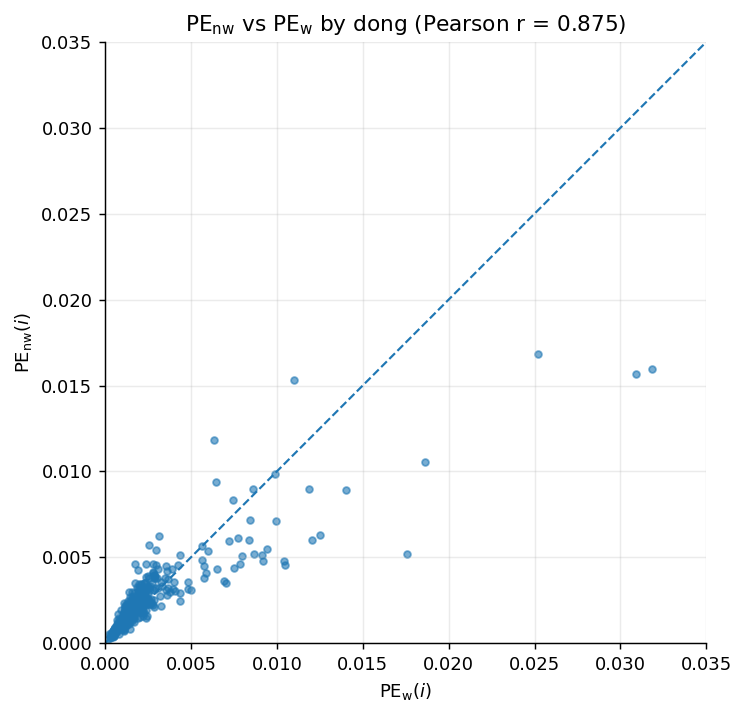

[Cell 3b] Fraction of dongs with PE_nw(i) < PE_w(i):
 - Unweighted (per dong):          24.883%
 - Pop-weighted (per resident):    29.615%
 - Trip-weighted (work arrivals):  51.994%
 - Trip-weighted (nonwork arrivals): 34.834%

[Cell 3b] PE_w - PE_nw statistics:
 - mean (unweighted): -0.000000
 - median (unweighted): -0.000218
 - mean (pop-weighted): 0.000357
 - q05/q50/q95 (pop-weighted): -0.001626, -0.000283,  0.004938

[Cell 3b] Correlations between PE_w and PE_nw:
 - Pearson r:  0.875
 - Spearman ρ: 0.935

[Cell 3b] Distribution distances (between PE_nw and PE_w):
 - Jensen–Shannon divergence: 0.020950 nats
 - Hellinger distance:        0.145380
 - Cosine similarity:         0.908380

[Cell 3b] Top 10 dongs where PE_w > PE_nw (largest positive diff):
 - 11560540: diff=+0.015883, PE_w=0.031827, PE_nw=0.015944, pop=97394
 - 11680640: diff=+0.015217, PE_w=0.030909, PE_nw=0.015692, pop=109974
 - 11545510: diff=+0.012422, PE_w=0.017585, PE_nw=0.005163, pop=62283
 - 11110615: diff=+0.008

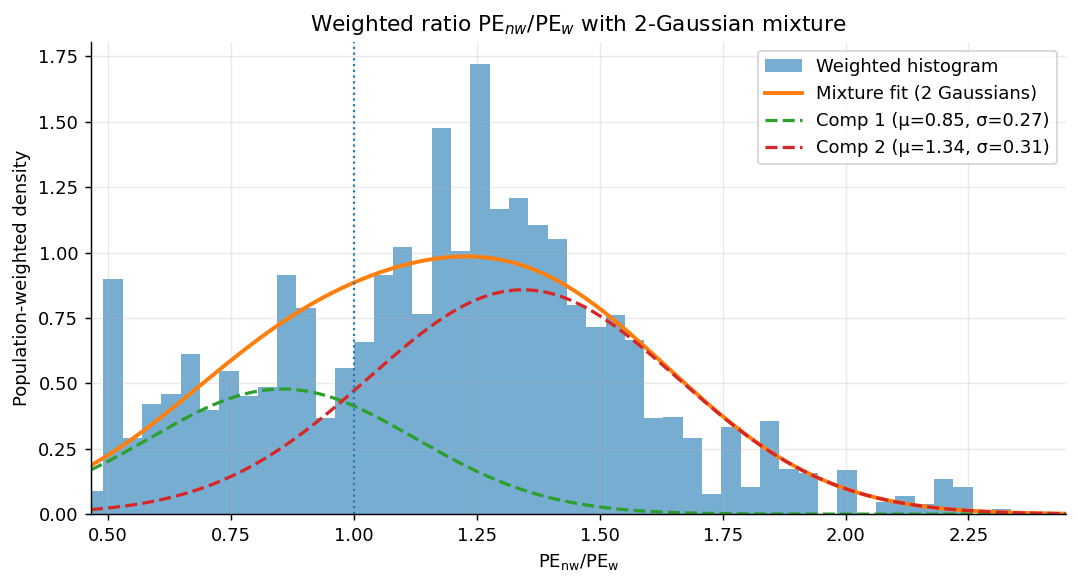

[Cell 3b][GMM] Components (sorted by mean):
 - Comp 1: mean=0.8542 (< 1), std=0.2701, weight=0.3239
 - Comp 2: mean=1.3438 (> 1), std=0.3144, weight=0.6761


In [8]:
# ============================================
# Cell 3b — SC/PE analysis
# Includes:
#  - Dense T matrices (aligned to existing `dong_ids`)
#  - SC(i) = T_ii / sum_j T_ij ; PE(i) = sum_j T_ji / sum_{m,n} T_{mn}
#  - Population-weighted histograms of SC (NW/W) with lognormal fits
#  - Population-weighted histograms of PE (NW/W) with lognormal fits
#  - Scatter PE_w vs PE_nw + stats (as in original)
#  - Population-weighted distribution of r = PE_nw/PE_w with 2-Gaussian mixture
#    (show both components and the mixture); print μ, σ, weight of components
#  - MOD: For each lognormal fit, also print mean & std in original scale
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import lognorm
from sklearn.mixture import GaussianMixture

# Reuse df_T_nw, df_T_w, dong_ids, and df_pop loaded earlier in Cell 3a

# ----- Build dense T matrices in the consistent dong order -----
def build_dense_T(dfT, dong_ids):
    """Return dense matrix T (n x n) in order of dong_ids."""
    idx_map = {d: i for i, d in enumerate(dong_ids)}
    n = len(dong_ids)
    T = np.zeros((n, n), dtype=float)
    for (o, d), cnt in dfT.groupby(["O_ADMDONG_CD", "D_ADMDONG_CD"])["CNT"].sum().items():
        i = idx_map.get(o); j = idx_map.get(d)
        if i is not None and j is not None:
            T[i, j] = float(cnt)
    return T

T_nw = build_dense_T(df_T_nw, dong_ids)
T_w  = build_dense_T(df_T_w , dong_ids)

# ----- SC and PE -----
def compute_SC(T):
    """SC(i) = T_ii / sum_j T_ij; 0 if OT(i)=0."""
    OT = T.sum(axis=1)  # outgoing
    diag = np.diag(T)
    with np.errstate(divide="ignore", invalid="ignore"):
        SC = np.where(OT > 0, diag / OT, 0.0)
    return SC, OT

def compute_PE(T):
    """PE(i) = sum_j T_ji / sum_{m,n} T_{mn}."""
    total = T.sum()
    IT = T.sum(axis=0)  # incoming per destination i
    with np.errstate(divide="ignore", invalid="ignore"):
        PE = np.where(total > 0, IT / total, 0.0)
    return PE, IT, total

SC_nw, OT_nw = compute_SC(T_nw)
SC_w , OT_w  = compute_SC(T_w )
PE_nw, IT_nw, total_nw = compute_PE(T_nw)
PE_w , IT_w , total_w  = compute_PE(T_w )

# Assemble per-dong frame for later reuse
df_SC_PE = pd.DataFrame({
    "dong_cd": dong_ids,
    "SC_nw": SC_nw,
    "SC_w": SC_w,
    "PE_nw": PE_nw,
    "PE_w": PE_w,
    "OT_nw": OT_nw,
    "IT_nw": IT_nw,
    "OT_w": OT_w,
    "IT_w": IT_w
})

# Attach de facto population (for weighting)
df_SC_PE = df_SC_PE.merge(
    df_pop[["dong_cd", "defacto_pop"]],
    on="dong_cd", how="left"
)
pop_ordered = df_SC_PE["defacto_pop"].astype(float).to_numpy()
pop_ordered = np.where(np.isfinite(pop_ordered) & (pop_ordered > 0), pop_ordered, 0.0)
tot_pop = float(pop_ordered.sum())
if tot_pop <= 0:
    print("[Cell 3b][WARN] All de facto populations are zero/NaN; population-weighted plots will equal unweighted.")

print("[Cell 3b] Example rows (SC/PE):")
display(df_SC_PE.head())

# ----- Helper: population-weighted lognormal fit and overlay -----
def weighted_lognorm_fit_and_plot(ax, data, weights, label, color=None):
    """
    Fits a log-normal to positive values in `data` using population weights.
    Plots histogram (density) and fitted curve on provided Axes.
    Returns (mu_log, sigma_log, mean_orig, std_orig).   # MOD: return mean & std
    """
    data = np.asarray(data, float)
    weights = np.asarray(weights, float)
    m = (data > 0) & np.isfinite(data) & np.isfinite(weights) & (weights >= 0)
    data, weights = data[m], weights[m]
    if data.size == 0 or np.nansum(weights) == 0:
        ax.text(0.5, 0.5, f"No positive data for {label}", ha="center", va="center", transform=ax.transAxes)
        return np.nan, np.nan, np.nan, np.nan

    # Weighted mean/var in log-space
    logx = np.log(data)
    mu = np.average(logx, weights=weights)
    sigma = np.sqrt(np.average((logx - mu)**2, weights=weights))

    # moments in original scale
    mean_orig = float(np.exp(mu + 0.5 * sigma**2))                # E[X]
    std_orig  = float(np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)))  # SD[X]

    # PDF for overlay (unchanged)
    s = sigma
    scale = np.exp(mu)
    x = np.linspace(data.min(), data.max(), 600)
    y = lognorm.pdf(x, s=s, scale=scale)

    ax.hist(data, bins=40, weights=weights, density=True, alpha=0.6, label=f"{label} (pop-weighted)")
    ax.plot(x, y, lw=2, label=f"{label} lognormal fit\nμ={mu:.2f}, σ={sigma:.2f}")
    return float(mu), float(sigma), mean_orig, std_orig

# ----- Population-weighted distributions: SC (NW vs W) -----
fig, ax = plt.subplots(figsize=(8.0, 4.6))
mu_sc_nw, sig_sc_nw, mean_sc_nw, std_sc_nw = weighted_lognorm_fit_and_plot(ax, SC_nw, pop_ordered, "SC_nw")
mu_sc_w , sig_sc_w , mean_sc_w , std_sc_w  = weighted_lognorm_fit_and_plot(ax, SC_w , pop_ordered, "SC_w")
ax.set_xlabel(r"$\mathrm{SC}(i)$")
ax.set_ylabel("Population-weighted density")
ax.set_title("Self-containment (SC) — population-weighted with lognormal fits")
ax.legend()
try:
    plt.tight_layout()
except Exception:
    pass
plt.show()

print("[Cell 3b][Lognormal] SC parameters:")
print(f" - SC_nw: mu_log={mu_sc_nw:.4f}, sigma_log={sig_sc_nw:.4f}, mean={mean_sc_nw:.6f}, std={std_sc_nw:.6f}")
print(f" - SC_w : mu_log={mu_sc_w :.4f}, sigma_log={sig_sc_w :.4f}, mean={mean_sc_w :.6f}, std={std_sc_w :.6f}")

# ----- Population-weighted distributions: PE (NW vs W) -----
fig, ax = plt.subplots(figsize=(8.0, 4.6))
mu_pe_nw, sig_pe_nw, mean_pe_nw, std_pe_nw = weighted_lognorm_fit_and_plot(ax, PE_nw, pop_ordered, "PE_nw")
mu_pe_w , sig_pe_w , mean_pe_w , std_pe_w  = weighted_lognorm_fit_and_plot(ax, PE_w , pop_ordered, "PE_w")
ax.set_xlabel(r"$\mathrm{PE}(i)$")
ax.set_ylabel("Population-weighted density")
ax.set_title("Pull-effect (PE) — population-weighted with lognormal fits")
ax.legend()
try:
    plt.tight_layout()
except Exception:
    pass
plt.show()

print("[Cell 3b][Lognormal] PE parameters:")
print(f" - PE_nw: mu_log={mu_pe_nw:.4f}, sigma_log={sig_pe_nw:.4f}, mean={mean_pe_nw:.6f}, std={std_pe_nw:.6f}")
print(f" - PE_w : mu_log={mu_pe_w :.4f}, sigma_log={sig_pe_w :.4f}, mean={mean_pe_w :.6f}, std={std_pe_w :.6f}")

# ----- Scatter: PE_w vs PE_nw + y=x + correlations -----
x = df_SC_PE["PE_w"].to_numpy(float)
y = df_SC_PE["PE_nw"].to_numpy(float)
mask = np.isfinite(x) & np.isfinite(y)
xv, yv = x[mask], y[mask]

U = max(xv.max() if xv.size else 0.0, yv.max() if yv.size else 0.0)
U = min(0.20, max(0.03, 1.10 * U))  # typical PE is small

r = np.nan
if xv.size >= 2:
    r = np.corrcoef(xv, yv)[0, 1]

plt.figure(figsize=(6.0, 5.6))
plt.scatter(xv, yv, s=14, alpha=0.6)
plt.plot([0, U], [0, U], linestyle="--", linewidth=1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, U); plt.ylim(0, U)
plt.xlabel(r"$\mathrm{PE}_{\mathrm{w}}(i)$")
plt.ylabel(r"$\mathrm{PE}_{\mathrm{nw}}(i)$")
title_suffix = f" (Pearson r = {r:.3f})" if np.isfinite(r) else ""
plt.title(f"$\\mathrm{{PE}}_\\mathrm{{nw}}$ vs $\\mathrm{{PE}}_\\mathrm{{w}}$ by dong{title_suffix}")
try:
    plt.tight_layout()
except Exception:
    pass
plt.show()

# ============================================
# PE_nw vs PE_w comparisons & fractions (same as original)
# ============================================

PEw  = df_SC_PE["PE_w"].to_numpy(float)
PEnw = df_SC_PE["PE_nw"].to_numpy(float)
popw = pop_ordered

mask = np.isfinite(PEw) & np.isfinite(PEnw)
PEw_v, PEnw_v, popw_v = PEw[mask], PEnw[mask], popw[mask]
dongs_v = np.array(dong_ids)[mask]

# Fractions where PE_nw < PE_w
cmp = PEnw_v < PEw_v
frac_unweighted     = float(cmp.mean()) if cmp.size else np.nan
frac_popweighted    = float(popw_v[cmp].sum() / popw_v.sum()) if popw_v.sum() > 0 else np.nan

# Trip-weighted variants (destination-trip views)
w_PEw  = PEw_v.copy()
w_PEnw = PEnw_v.copy()
frac_trip_weighted_work    = float(w_PEw[cmp].sum()  / w_PEw.sum())  if w_PEw.sum()  > 0 else np.nan
frac_trip_weighted_nonwork = float(w_PEnw[cmp].sum() / w_PEnw.sum()) if w_PEnw.sum() > 0 else np.nan

print("[Cell 3b] Fraction of dongs with PE_nw(i) < PE_w(i):")
print(f" - Unweighted (per dong):          {frac_unweighted:.3%}")
print(f" - Pop-weighted (per resident):    {frac_popweighted:.3%}")
print(f" - Trip-weighted (work arrivals):  {frac_trip_weighted_work:.3%}")
print(f" - Trip-weighted (nonwork arrivals): {frac_trip_weighted_nonwork:.3%}")

# Differences, ratios, and summary stats
diff  = PEw_v - PEnw_v

def wmean(x, w):
    x = np.asarray(x); w = np.asarray(w)
    s = w.sum()
    return float(np.sum(x * w) / s) if s > 0 else np.nan

def wquantile(x, w, q):
    x = np.asarray(x); w = np.asarray(w)
    m = np.isfinite(x) & np.isfinite(w) & (w >= 0)
    x, w = x[m], w[m]
    if w.sum() == 0 or x.size == 0:
        return np.nan
    order = np.argsort(x)
    x, w = x[order], w[order]
    cw = np.cumsum(w); cw = cw / cw[-1]
    return float(np.interp(q, cw, x))

print("\n[Cell 3b] PE_w - PE_nw statistics:")
print(f" - mean (unweighted): {np.nanmean(diff):.6f}")
print(f" - median (unweighted): {np.nanmedian(diff):.6f}")
print(f" - mean (pop-weighted): {wmean(diff, popw_v):.6f}")
print(f" - q05/q50/q95 (pop-weighted): {wquantile(diff, popw_v, 0.05): .6f}, "
      f"{wquantile(diff, popw_v, 0.50): .6f}, {wquantile(diff, popw_v, 0.95): .6f}")

# Correlations (level & rank)
pearson = np.corrcoef(PEw_v, PEnw_v)[0, 1] if PEw_v.size >= 2 else np.nan
spearman = (pd.Series(PEw_v).rank(method="average").corr(pd.Series(PEnw_v).rank(method="average"))
            if PEw_v.size >= 2 else np.nan)
print("\n[Cell 3b] Correlations between PE_w and PE_nw:")
print(f" - Pearson r:  {pearson:.3f}")
print(f" - Spearman ρ: {spearman:.3f}")

# Distribution distances on the simplex (PE vectors)
def _normalize(p):
    p = np.asarray(p, float)
    s = p.sum()
    return p / s if s > 0 else p

def js_divergence(p, q):
    p = _normalize(p); q = _normalize(q)
    m = 0.5 * (p + q)
    def _kl(a, b):
        mask = (a > 0) & (b > 0)
        return np.sum(a[mask] * np.log(a[mask] / b[mask]))
    return 0.5 * _kl(p, m) + 0.5 * _kl(q, m)  # nats

def hellinger(p, q):
    p = _normalize(p); q = _normalize(q)
    return float(np.sqrt(1.0 - np.sum(np.sqrt(p * q))))

def cosine_sim(p, q):
    p = np.asarray(p, float); q = np.asarray(q, float)
    denom = np.linalg.norm(p) * np.linalg.norm(q)
    return float(np.dot(p, q) / denom) if denom > 0 else np.nan

JS   = js_divergence(PEnw_v, PEw_v)
H    = hellinger(PEnw_v, PEw_v)
COS  = cosine_sim(PEnw_v, PEw_v)
print("\n[Cell 3b] Distribution distances (between PE_nw and PE_w):")
print(f" - Jensen–Shannon divergence: {JS:.6f} nats")
print(f" - Hellinger distance:        {H:.6f}")
print(f" - Cosine similarity:         {COS:.6f}")

# Top/bottom dongs by difference (PE_w - PE_nw)
k = 10
idx_top = np.argsort(diff)[-k:][::-1]
idx_bot = np.argsort(diff)[:k]

print(f"\n[Cell 3b] Top {k} dongs where PE_w > PE_nw (largest positive diff):")
for i in idx_top:
    print(f" - {dongs_v[i]}: diff={diff[i]:+.6f}, PE_w={PEw_v[i]:.6f}, PE_nw={PEnw_v[i]:.6f}, pop={int(popw_v[i])}")

print(f"\n[Cell 3b] Top {k} dongs where PE_w < PE_nw (most negative diff):")
for i in idx_bot:
    print(f" - {dongs_v[i]}: diff={diff[i]:+.6f}, PE_w={PEw_v[i]:.6f}, PE_nw={PEnw_v[i]:.6f}, pop={int(popw_v[i])}")

# -----------------------------------------------------------
# Population-weighted distribution of r = PE_nw / PE_w with 2-Gaussian mixture
# -----------------------------------------------------------
ratio_raw = np.divide(PEnw_v, PEw_v, out=np.full_like(PEw_v, np.nan), where=(PEw_v > 0))
mask_r = np.isfinite(ratio_raw) & (ratio_raw > 0)
r = ratio_raw[mask_r]
w_r = popw_v[mask_r]

if r.size > 1 and np.nansum(w_r) > 0:
    # Approximate weighted fit: replicate observations proportional to normalized weights
    w_scaled = np.clip((w_r / np.nanmax(w_r)) * 200, 1, None).astype(int)
    r_rep = np.repeat(r, w_scaled).reshape(-1, 1)

    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(r_rep)

    # Sort components by mean
    means = gmm.means_.flatten()
    stds  = np.sqrt(gmm.covariances_.flatten())
    weights = gmm.weights_.flatten()
    order = np.argsort(means)
    means, stds, weights = means[order], stds[order], weights[order]

    xmin = max(0.0, float(np.nanpercentile(r, 0.5)))
    xmax = min(5.0, 1.10 * float(np.nanpercentile(r, 99.5)))
    x = np.linspace(xmin, xmax, 600)

    def _gauss(x, mu, sig):
        return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-0.5 * ((x - mu) / sig)**2)

    mix = weights[0]*_gauss(x, means[0], stds[0]) + weights[1]*_gauss(x, means[1], stds[1])

    fig, ax = plt.subplots(figsize=(8.4, 4.6))
    ax.hist(r, bins=60, density=True, weights=w_r, alpha=0.6, label="Weighted histogram")
    ax.plot(x, mix, lw=2.2, label="Mixture fit (2 Gaussians)")
    ax.plot(x, weights[0]*_gauss(x, means[0], stds[0]), lw=1.8, linestyle="--",
            label=f"Comp 1 (μ={means[0]:.2f}, σ={stds[0]:.2f})")
    ax.plot(x, weights[1]*_gauss(x, means[1], stds[1]), lw=1.8, linestyle="--",
            label=f"Comp 2 (μ={means[1]:.2f}, σ={stds[1]:.2f})")
    ax.axvline(1.0, linestyle=":", lw=1.2)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r"$\mathrm{PE}_{\mathrm{nw}}/\mathrm{PE}_{\mathrm{w}}$")
    ax.set_ylabel("Population-weighted density")
    ax.set_title("Weighted ratio $\\mathrm{PE}_{nw}/\\mathrm{PE}_{w}$ with 2-Gaussian mixture")
    ax.legend()
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()

    print("[Cell 3b][GMM] Components (sorted by mean):")
    for k in range(2):
        side = "< 1" if means[k] < 1 else "> 1"
        print(f" - Comp {k+1}: mean={means[k]:.4f} ({side}), std={stds[k]:.4f}, weight={weights[k]:.4f}")
else:
    print("[Cell 3b][GMM] Skipped: insufficient finite ratio data or weights.")


# --- heatmap ratios PEnw/PEw versus SCnw/SCw and seoul map

## testing long lat file

In [10]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.2 MB/s eta 0:00:00


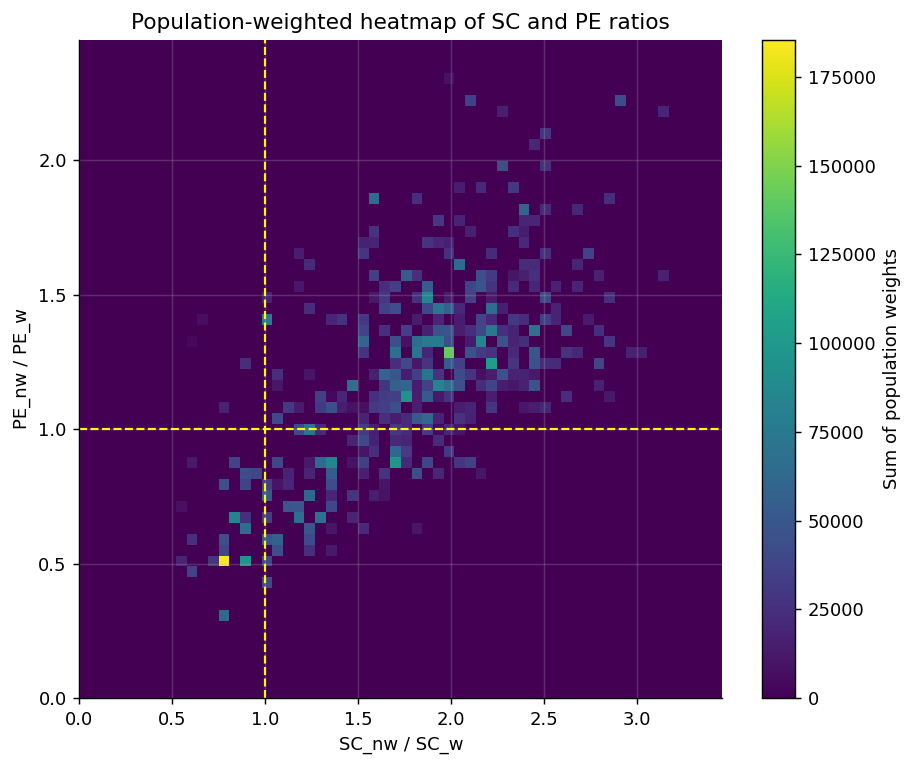

[Cell 3c] Heatmap done with 426 valid dongs.
Quadrant statistics (x=SC_nw/SC_w, y=PE_nw/PE_w):
 - Q1 (x>1, y>1):  316 dongs |  69.90%
 - Q2 (x<1, y>1):    4 dongs |   0.49%
 - Q3 (x<1, y<1):   25 dongs |   9.89%
 - Q4 (x>1, y<1):   81 dongs |  19.73%
[Cell 3c] Initial centroid ranges: lon∈[937697.417,971511.605], lat∈[1938044.019,1965192.021]
[Cell 3c][WARN] Centroid ranges look off for WGS84; ensure file is lon/lat in degrees.
[Cell 3c] Using centroid ranges:   lon∈[937697.417,971511.605], lat∈[1938044.019,1965192.021]


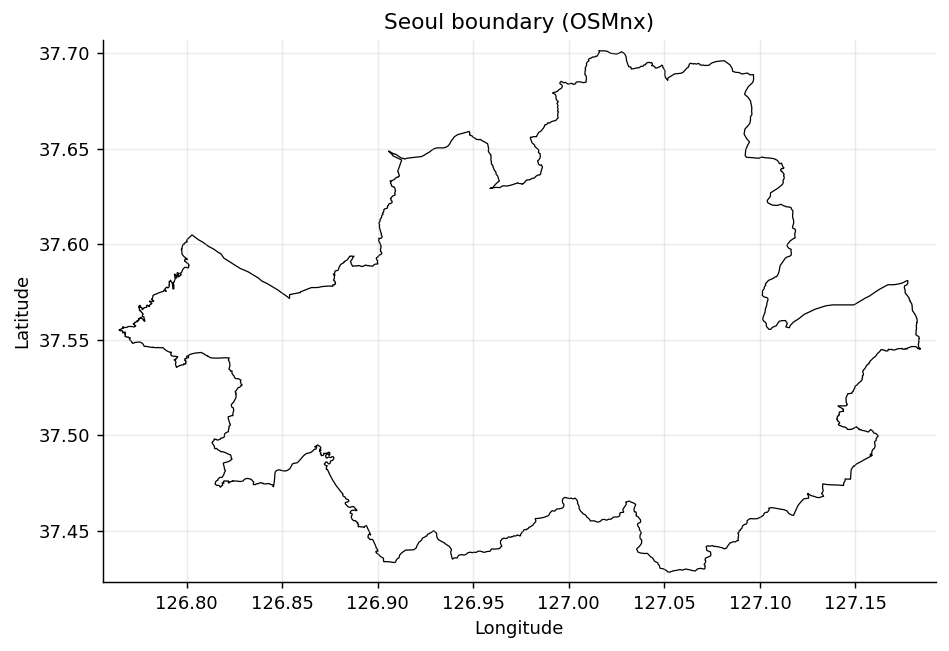

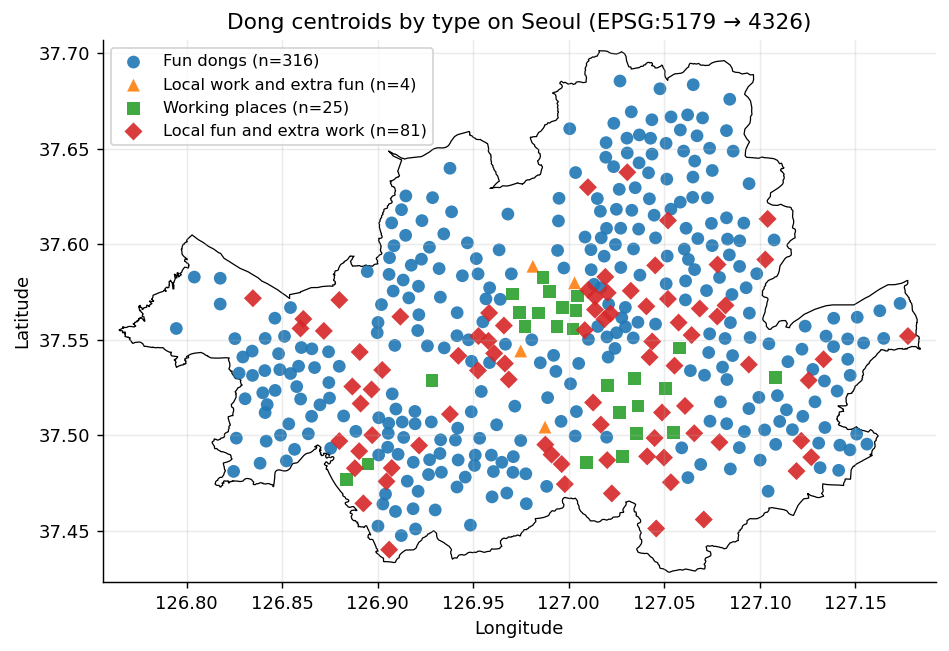

[Cell 3c] Plotted 426 centroids. lon∈[126.795,127.177], lat∈[37.440,37.685]  (EPSG:5179 → 4326)


In [11]:
# ============================================
# Cell 3c — Heatmap of ratios + quadrant stats
#           + (1) Seoul basemap
#           + (2) Seoul + dong centroids by quadrant
#   x = SC_nw / SC_w
#   y = PE_nw / PE_w
#   Centroids file: ./data/Seoul426dong_x_y.xlsx
#       col1 = Dongcode, col2 = longitude, col3 = latitude  (per user)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- Ratios and heatmap (unchanged core) ---------
SC_nw = df_SC_PE["SC_nw"].to_numpy(float)
SC_w  = df_SC_PE["SC_w" ].to_numpy(float)
PE_nw = df_SC_PE["PE_nw"].to_numpy(float)
PE_w  = df_SC_PE["PE_w" ].to_numpy(float)
w_pop = np.asarray(pop_ordered, float)

mask_base = (
    np.isfinite(SC_nw) & np.isfinite(SC_w) & (SC_w > 0) &
    np.isfinite(PE_nw) & np.isfinite(PE_w) & (PE_w > 0) &
    np.isfinite(w_pop) & (w_pop >= 0)
)

x_ratio_all = np.divide(SC_nw, SC_w, out=np.full_like(SC_nw, np.nan), where=(SC_w > 0))
y_ratio_all = np.divide(PE_nw, PE_w, out=np.full_like(PE_w, np.nan), where=(PE_w > 0))
mask_pos = mask_base & (x_ratio_all > 0) & (y_ratio_all > 0)

xv = x_ratio_all[mask_pos]
yv = y_ratio_all[mask_pos]
wv = w_pop[mask_pos]
dongs_valid = np.array(dong_ids)[mask_pos]

if xv.size == 0:
    raise ValueError("[Cell 3c] No valid ratios to plot.")

# Heatmap bounds
qx = float(np.nanquantile(xv, 0.995))
qy = float(np.nanquantile(yv, 0.995))
xmax = min(5.0, max(2.0, 1.10 * qx))
ymax = min(5.0, max(2.0, 1.10 * qy))

# Weighted 2D histogram
bins_2d = 60
xedges = np.linspace(0.0, xmax, bins_2d + 1)
yedges = np.linspace(0.0, ymax, bins_2d + 1)
H_wgt, _, _ = np.histogram2d(xv, yv, bins=[xedges, yedges], weights=wv)

# Plot heatmap
fig, ax = plt.subplots(figsize=(7.2, 6.0))
im = ax.pcolormesh(xedges, yedges, H_wgt.T, shading="auto")
ax.axvline(1.0, linestyle="--", color="yellow", linewidth=1.2)
ax.axhline(1.0, linestyle="--", color="yellow", linewidth=1.2)
ax.set_xlim(0, xmax); ax.set_ylim(0, ymax)
ax.set_xlabel("SC_nw / SC_w")
ax.set_ylabel("PE_nw / PE_w")
ax.set_title("Population-weighted heatmap of SC and PE ratios")
cbar = fig.colorbar(im, ax=ax); cbar.set_label("Sum of population weights")
try: plt.tight_layout()
except Exception: pass
plt.show()

# Quadrant stats
Q1 = (xv > 1) & (yv > 1)
Q2 = (xv < 1) & (yv > 1)
Q3 = (xv < 1) & (yv < 1)
Q4 = (xv > 1) & (yv < 1)
tot_pop_valid = float(np.nansum(wv))
def _count_frac(msk):
    return int(np.sum(msk)), (float(np.nansum(wv[msk]) / tot_pop_valid) if tot_pop_valid > 0 else np.nan)
c1, f1 = _count_frac(Q1); c2, f2 = _count_frac(Q2); c3, f3 = _count_frac(Q3); c4, f4 = _count_frac(Q4)

print(f"[Cell 3c] Heatmap done with {xv.size} valid dongs.")
print("Quadrant statistics (x=SC_nw/SC_w, y=PE_nw/PE_w):")
print(f" - Q1 (x>1, y>1): {c1:4d} dongs | {f1*100:6.2f}%")
print(f" - Q2 (x<1, y>1): {c2:4d} dongs | {f2*100:6.2f}%")
print(f" - Q3 (x<1, y<1): {c3:4d} dongs | {f3*100:6.2f}%")
print(f" - Q4 (x>1, y<1): {c4:4d} dongs | {f4*100:6.2f}%")

# ============================================================
# Maps: (1) Seoul basemap, then (2) Seoul + centroids by quadrant
# ============================================================

# Build per-dong table with ratios and quadrants
df_rat = pd.DataFrame({
    "dong_cd": np.array(dong_ids)[mask_pos],
    "x_ratio": xv,
    "y_ratio": yv,
})
def _quad(x, y):
    if (x > 1) and (y > 1): return "Q1"
    if (x < 1) and (y > 1): return "Q2"
    if (x < 1) and (y < 1): return "Q3"
    if (x > 1) and (y < 1): return "Q4"
    return "On lines"
df_rat["quadrant"] = [_quad(a, b) for a, b in zip(df_rat["x_ratio"], df_rat["y_ratio"])]

# Load centroids
cent_file = os.path.join(data_dir, "Seoul426dong_x_y.xlsx")
df_xy = pd.read_excel(cent_file, engine="openpyxl")
if df_xy.shape[1] < 3:
    raise ValueError("[Cell 3c] Centroid file must have ≥3 columns (code, lon, lat).")
df_xy = df_xy.iloc[:, :3].copy()
df_xy.columns = ["dong_cd", "lon_raw", "lat_raw"]
df_xy["dong_cd"] = df_xy["dong_cd"].astype(str)

# Convert to numeric
df_xy["lon"] = pd.to_numeric(df_xy["lon_raw"], errors="coerce")
df_xy["lat"] = pd.to_numeric(df_xy["lat_raw"], errors="coerce")

# --- Sanity checks & auto-fix for lon/lat ---
def _range_info(series):
    return float(np.nanmin(series)), float(np.nanmax(series))

lon_min, lon_max = _range_info(df_xy["lon"])
lat_min, lat_max = _range_info(df_xy["lat"])
print(f"[Cell 3c] Initial centroid ranges: lon∈[{lon_min:.3f},{lon_max:.3f}], lat∈[{lat_min:.3f},{lat_max:.3f}]")

# Typical Seoul bounds (loose): lon ~ [126, 129], lat ~ [36, 39]
def _is_lon_lat_ok(lon_min, lon_max, lat_min, lat_max):
    return (126 <= lon_min <= 129 or 126 <= lon_max <= 129) and (36 <= lat_min <= 39 or 36 <= lat_max <= 39)

# If swapped, try swapping
_swapped = False
if not _is_lon_lat_ok(lon_min, lon_max, lat_min, lat_max):
    # Try swap
    lon2, lat2 = df_xy["lat"].copy(), df_xy["lon"].copy()
    lon2_min, lon2_max = _range_info(lon2)
    lat2_min, lat2_max = _range_info(lat2)
    if _is_lon_lat_ok(lon2_min, lon2_max, lat2_min, lat2_max):
        df_xy["lon"], df_xy["lat"] = lon2, lat2
        _swapped = True
        print("[Cell 3c] NOTE: Columns looked swapped. Applied lon<->lat swap.")
    else:
        # Values might be projected (meters). We can't reproject without CRS;
        # just warn and continue; map overlay may look off.
        print("[Cell 3c][WARN] Centroid ranges look off for WGS84; ensure file is lon/lat in degrees.")

# If not swapped above, set lon/lat as parsed
if not _swapped:
    df_xy["lon"] = df_xy["lon"]
    df_xy["lat"] = df_xy["lat"]

lon_min, lon_max = _range_info(df_xy["lon"])
lat_min, lat_max = _range_info(df_xy["lat"])
print(f"[Cell 3c] Using centroid ranges:   lon∈[{lon_min:.3f},{lon_max:.3f}], lat∈[{lat_min:.3f},{lat_max:.3f}]")

# Merge with ratios (inner join)
df_map = pd.merge(df_rat, df_xy[["dong_cd", "lon", "lat"]], on="dong_cd", how="inner")
df_map = df_map[np.isfinite(df_map["lon"]) & np.isfinite(df_map["lat"])].copy()

# OSMnx basemap
use_plain_scatter = False
seoul_geom = None
try:
    import osmnx as ox
    ox.settings.log_console = False
    gdf_city = ox.geocode_to_gdf("Seoul, South Korea")
    if (gdf_city is not None) and (len(gdf_city) > 0):
        seoul_geom = gdf_city.to_crs(epsg=4326)  # WGS84 lon/lat
    else:
        use_plain_scatter = True
except Exception as e:
    print(f"[Cell 3c][INFO] OSMnx not available or geocoding failed ({e}). Falling back to plain scatter.")
    use_plain_scatter = True




# ============================================
# Cell 3c — MAPS ONLY (uses EPSG:5178 with axis c1,c2)
#   (1) Seoul basemap
#   (2) Seoul + dong centroids by quadrant (Q1–Q4)
# Requirements in memory: df_SC_PE, pop_ordered, dong_ids
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Build ratios & quadrant table if missing ----------
if 'df_rat' not in globals():
    SC_nw = df_SC_PE["SC_nw"].to_numpy(float)
    SC_w  = df_SC_PE["SC_w" ].to_numpy(float)
    PE_nw = df_SC_PE["PE_nw"].to_numpy(float)
    PE_w  = df_SC_PE["PE_w" ].to_numpy(float)
    w_pop = np.asarray(pop_ordered, float)

    mask_base = (
        np.isfinite(SC_nw) & np.isfinite(SC_w) & (SC_w > 0) &
        np.isfinite(PE_nw) & np.isfinite(PE_w) & (PE_w > 0) &
        np.isfinite(w_pop) & (w_pop >= 0)
    )
    x_ratio_all = np.divide(SC_nw, SC_w, out=np.full_like(SC_nw, np.nan), where=(SC_w > 0))
    y_ratio_all = np.divide(PE_nw, PE_w, out=np.full_like(PE_w, np.nan), where=(PE_w > 0))
    mask_pos = mask_base & (x_ratio_all > 0) & (y_ratio_all > 0)

    def _quad(x, y):
        if (x > 1) and (y > 1): return "Q1"
        if (x < 1) and (y > 1): return "Q2"
        if (x < 1) and (y < 1): return "Q3"
        if (x > 1) and (y < 1): return "Q4"
        return "On lines"

    df_rat = pd.DataFrame({
        "dong_cd": np.array(dong_ids),
        "x_ratio": x_ratio_all,
        "y_ratio": y_ratio_all
    })
    df_rat = df_rat.loc[mask_pos, :].copy()
    df_rat["quadrant"] = [_quad(a, b) for a, b in zip(df_rat["x_ratio"], df_rat["y_ratio"])]

# ---------- Read centroids (first 3 cols), decimal commas → dots ----------
cent_file = os.path.join(data_dir, "Seoul426dong_x_y.xlsx")
df_xy = pd.read_excel(cent_file, engine="openpyxl", usecols=[0, 1, 2])
df_xy.columns = ["dong_cd", "c1_raw", "c2_raw"]

def _to_num(v):
    s = str(v).strip().replace(" ", "").replace(",", ".")
    return pd.to_numeric(s, errors="coerce")

df_xy["c1"] = df_xy["c1_raw"].map(_to_num)
df_xy["c2"] = df_xy["c2_raw"].map(_to_num)
df_xy = df_xy[np.isfinite(df_xy["c1"]) & np.isfinite(df_xy["c2"])].copy()
df_xy["dong_cd"] = df_xy["dong_cd"].astype(str)

# ---------- Reproject from EPSG:5179 (axis order: c1,c2) → WGS84 ----------
import geopandas as gpd
from shapely.geometry import Point

gdf_xy = gpd.GeoDataFrame(
    df_xy,
    geometry=gpd.points_from_xy(df_xy["c1"], df_xy["c2"]),  # EPSG:5179 uses meters; x=c1, y=c2
    crs="EPSG:5179"
).to_crs(epsg=4326)

df_xy["lon"] = gdf_xy.geometry.x
df_xy["lat"] = gdf_xy.geometry.y
df_xy = df_xy[["dong_cd", "lon", "lat"]]

# ---------- Merge ratios with centroids ----------
df_map = pd.merge(df_rat, df_xy, on="dong_cd", how="inner")
df_map = df_map[np.isfinite(df_map["lon"]) & np.isfinite(df_map["lat"])].copy()

# ---------- (1) Seoul basemap via OSMnx (fallback: empty frame) ----------
use_plain_scatter = False
seoul_geom = None
try:
    import osmnx as ox
    ox.settings.log_console = False
    gdf_city = ox.geocode_to_gdf("Seoul, South Korea")
    if (gdf_city is not None) and (len(gdf_city) > 0):
        seoul_geom = gdf_city.to_crs(epsg=4326)
    else:
        use_plain_scatter = True
except Exception as e:
    print(f"[Cell 3c][INFO] OSMnx not available or geocoding failed ({e}). Falling back to plain scatter.")
    use_plain_scatter = True

fig1, ax1 = plt.subplots(figsize=(7.4, 7.0))
if not use_plain_scatter and seoul_geom is not None:
    seoul_geom.plot(ax=ax1, facecolor="white", edgecolor="black", linewidth=0.7)
    minx, miny, maxx, maxy = seoul_geom.total_bounds
    pad_x = (maxx - minx) * 0.02; pad_y = (maxy - miny) * 0.02
    ax1.set_xlim(minx - pad_x, maxx + pad_x)
    ax1.set_ylim(miny - pad_y, maxy + pad_y)
    ax1.set_title("Seoul boundary (OSMnx)")
else:
    ax1.set_title("Seoul map placeholder (OSMnx unavailable)")
ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude")
ax1.set_aspect("equal", adjustable="box")
try: plt.tight_layout()
except Exception: pass
plt.show()

# ---------- (2) Seoul + centroids by quadrant (custom legend & larger markers) ----------
quad_markers = {"Q1": "o", "Q2": "^", "Q3": "s", "Q4": "D"}
quad_colors  = {"Q1": "#1f77b4", "Q2": "#ff7f0e", "Q3": "#2ca02c", "Q4": "#d62728"}
quad_labels  = {
    "Q1": "Fun dongs",
    "Q2": "Local work and extra fun",
    "Q3": "Working places",
    "Q4": "Local fun and extra work"
}

fig2, ax2 = plt.subplots(figsize=(7.4, 7.0))
if not use_plain_scatter and seoul_geom is not None:
    seoul_geom.plot(ax=ax2, facecolor="white", edgecolor="black", linewidth=0.7)

for q in ["Q1", "Q2", "Q3", "Q4"]:
    dfq = df_map[df_map["quadrant"] == q]
    if dfq.empty:
        continue
    ax2.scatter(dfq["lon"].values, dfq["lat"].values,
                s=50, marker=quad_markers[q], c=quad_colors[q],
                alpha=0.9, label=f"{quad_labels[q]} (n={len(dfq)})",
                edgecolors="none")

ax2.set_xlabel("Longitude"); ax2.set_ylabel("Latitude")
ax2.set_title("Dong centroids by type on Seoul (EPSG:5179 → 4326)")
ax2.legend(loc="best", fontsize=9, frameon=True)
ax2.set_aspect("equal", adjustable="box")

# Fit extent to geometry if available; else to points
if not use_plain_scatter and seoul_geom is not None:
    minx, miny, maxx, maxy = seoul_geom.total_bounds
    minx = min(minx, df_map["lon"].min()); maxx = max(maxx, df_map["lon"].max())
    miny = min(miny, df_map["lat"].min()); maxy = max(maxy, df_map["lat"].max())
    pad_x = (maxx - minx) * 0.02; pad_y = (maxy - miny) * 0.02
    ax2.set_xlim(minx - pad_x, maxx + pad_x)
    ax2.set_ylim(miny - pad_y, maxy + pad_y)
else:
    if not df_map.empty:
        minx, maxx = df_map["lon"].min(), df_map["lon"].max()
        miny, maxy = df_map["lat"].min(), df_map["lat"].max()
        pad_x = (maxx - minx) * 0.02; pad_y = (maxy - miny) * 0.02
        ax2.set_xlim(minx - pad_x, maxx + pad_x)
        ax2.set_ylim(miny - pad_y, maxy + pad_y)

try:
    plt.tight_layout()
except Exception:
    pass
plt.show()

# Sanity printout
minx, miny, maxx, maxy = df_map["lon"].min(), df_map["lat"].min(), df_map["lon"].max(), df_map["lat"].max()
print(f"[Cell 3c] Plotted {len(df_map)} centroids. lon∈[{minx:.3f},{maxx:.3f}], lat∈[{miny:.3f},{maxy:.3f}]  (EPSG:5179 → 4326)")




## (Fig 3d) with dong boundaries


[Cell 3c] Loaded: 426 centroids, 426 polygons.
[Cell 3c] Attribute join: best_col=ADM_CD, matched=32/426
[Cell 3c] After fallback: polygons colored=426
[Cell 3c] Polygons forced to centroid quadrants: 426


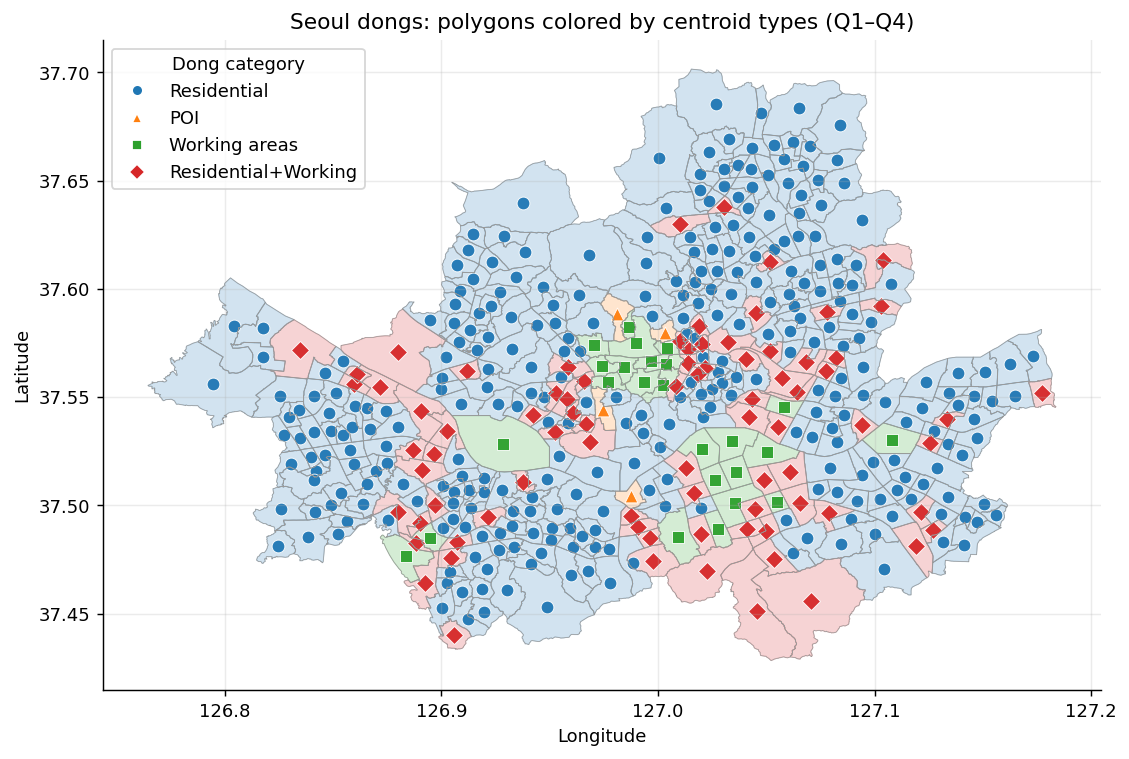

In [14]:
# ============================================
# Cell 3c — Seoul map: dong boundaries colored by centroid quadrant + centroid markers
# Polygons are forced to adopt the centroid quadrant (symbol color authoritative)
# ============================================

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ---------- 0) Helpers ----------
def _norm_code_series(s: pd.Series, target_len: int | None = None) -> pd.Series:
    out = s.astype(str).str.strip()
    out = out.str.replace(r"\.0$", "", regex=True)
    out = out.str.replace(r"[^0-9]", "", regex=True)
    if target_len is not None and target_len > 0:
        out = out.str.zfill(target_len)
    return out

def _guess_code_columns(cols):
    cand = [
        "ADM_CD","EMD_CD","EMDCD","DONG_CD","DONGCODE","DONG_CD8","ADMDR_CD",
        "adm_cd","emd_cd","emdcd","dong_cd","dongcode","code","cd"
    ]
    low = [c.lower() for c in cand]
    return [c for c in cols if c.lower() in low]

# ---------- 1) Load polygons ----------
shp_path_uploaded = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public/Seoul_426_dong_boundary.shp"
if os.path.exists(shp_path_uploaded):
    shp_path = shp_path_uploaded
else:
    shp_dir = os.path.join(data_dir, "Seoul_426_dong_boundary")
    shp_path = None
    if os.path.isdir(shp_dir):
        for fn in os.listdir(shp_dir):
            if fn.lower().endswith(".shp"):
                shp_path = os.path.join(shp_dir, fn)
                break

if shp_path is None or not os.path.exists(shp_path):
    raise FileNotFoundError("Could not find a .shp file.")

gdf_bnd = gpd.read_file(shp_path)
if gdf_bnd.crs is None:
    gdf_bnd = gdf_bnd.set_crs(epsg=5179)

gdf_bnd_wgs = gdf_bnd.to_crs(4326)

# ---------- 2) Centroid GDF (KEEPING quadrant from df_rat — authoritative colors) ----------
df_xy_q = df_xy.merge(df_rat[['dong_cd','quadrant']], on='dong_cd', how='left', validate='1:1')
gdf_pts = gpd.GeoDataFrame(
    df_xy_q,
    geometry=gpd.points_from_xy(df_xy_q['lon'], df_xy_q['lat']),
    crs=4326
)

print(f"[Cell 3c] Loaded: {len(gdf_pts)} centroids, {len(gdf_bnd)} polygons.")

# ---------- 3) Attribute join by admin code ----------
target_len = (
    df_rat['dong_cd']
    .astype(str)
    .str.replace(r"\.0$", "", regex=True)
    .str.len()
    .value_counts()
    .idxmax()
)

code_cols = _guess_code_columns(list(gdf_bnd.columns))
if not code_cols:
    for c in gdf_bnd.columns:
        if pd.api.types.is_string_dtype(gdf_bnd[c]) or pd.api.types.is_integer_dtype(gdf_bnd[c]):
            code_cols.append(c)

gdf_bnd_attr = gdf_bnd_wgs.copy()
gdf_bnd_attr["quadrant"] = pd.Series([None]*len(gdf_bnd_attr), dtype="object")

best_matches = -1
best_col = None

df_rat_map = df_rat[['dong_cd','quadrant']].copy()
df_rat_map['dong_cd_norm'] = _norm_code_series(df_rat_map['dong_cd'], target_len)

for col in code_cols:
    try:
        shp_codes = _norm_code_series(gdf_bnd[col], target_len)
        merged = gdf_bnd_wgs.copy()
        merged['dong_cd_norm'] = shp_codes

        merged = merged.merge(
            df_rat_map[['dong_cd_norm','quadrant']],
            on='dong_cd_norm', how='left', validate='1:1'
        )

        nm = merged['quadrant'].notna().sum()
        if nm > best_matches:
            best_matches = nm
            best_col = col
            gdf_bnd_attr['dong_cd_norm'] = merged['dong_cd_norm']
            gdf_bnd_attr['quadrant'] = merged['quadrant'].astype("object")

    except Exception:
        continue

print(f"[Cell 3c] Attribute join: best_col={best_col}, matched={best_matches}/{len(gdf_bnd_attr)}")

# ---------- 4) Fallback for polygons lacking quadrant ----------
if best_matches < len(gdf_bnd_attr):
    poly_m = gdf_bnd.to_crs(5179).copy()
    pts_m  = gdf_pts.to_crs(5179).copy()

    poly_cent = poly_m.copy()
    poly_cent['geometry'] = poly_cent.geometry.centroid

    j_near = gpd.sjoin_nearest(
        poly_cent[['geometry']].reset_index(),
        pts_m[['dong_cd','quadrant','geometry']],
        how='left'
    )

    q_by_poly = pd.Series([None]*len(gdf_bnd_attr), dtype='object')
    ok = ~j_near['quadrant'].isna()
    q_by_poly.iloc[j_near.loc[ok,'index'].values] = j_near.loc[ok,'quadrant'].values

    need_fill = gdf_bnd_attr['quadrant'].isna()
    gdf_bnd_attr.loc[need_fill, 'quadrant'] = q_by_poly.loc[need_fill].values

print(f"[Cell 3c] After fallback: polygons colored={gdf_bnd_attr['quadrant'].notna().sum()}")

# ---------- 4b) FORCE polygon quadrant = nearest centroid quadrant ----------
# (This ensures polygon color matches centroid symbol color)
poly_m2 = gdf_bnd_attr.to_crs(5179).copy()
pts_m2  = gdf_pts.to_crs(5179).copy()

poly_cent2 = poly_m2.copy()
poly_cent2['geometry'] = poly_cent2.geometry.centroid

j_poly = gpd.sjoin_nearest(
    poly_cent2[['geometry']].reset_index(),
    pts_m2[['quadrant','geometry']],
    how='left'
)

q_poly = pd.Series(index=gdf_bnd_attr.index, dtype='object')
okp = ~j_poly['quadrant'].isna()
q_poly.iloc[j_poly.loc[okp, 'index'].values] = j_poly.loc[okp, 'quadrant'].values

gdf_bnd_attr['quadrant'] = q_poly.values

print(f"[Cell 3c] Polygons forced to centroid quadrants: {gdf_bnd_attr['quadrant'].notna().sum()}")

# ---------- 5) Plot ----------
quad_markers = {"Q1": "o", "Q2": "^", "Q3": "s", "Q4": "D"}
quad_colors  = {"Q1": "#1f77b4", "Q2": "#ff7f0e", "Q3": "#2ca02c", "Q4": "#d62728"}
quad_labels  = {
    "Q1": "Residential",
    "Q2": "POI",
    "Q3": "Working areas",
    "Q4": "Residential+Working"
}

fig, ax = plt.subplots(figsize=(8.8, 8.2))

gdf_bnd_wgs.boundary.plot(ax=ax, color="#999999", linewidth=0.4)

# polygons (now follow centroid colors)
for q in ["Q1","Q2","Q3","Q4"]:
    sel = gdf_bnd_attr[gdf_bnd_attr["quadrant"] == q]
    if not sel.empty:
        sel.plot(ax=ax, facecolor=quad_colors[q], edgecolor=quad_colors[q],
                 linewidth=0.6, alpha=0.20)

# centroid markers (original df_rat color)
for q in ["Q1","Q2","Q3","Q4"]:
    pts_q = gdf_pts[gdf_pts["quadrant"] == q]
    if not pts_q.empty:
        ax.scatter(pts_q.geometry.x, pts_q.geometry.y,
                   s=50, c=quad_colors[q], marker=quad_markers[q],
                   alpha=0.95, edgecolors="white", linewidths=0.5,
                   label=f"{quad_labels[q]} (n={len(pts_q)})")

ax.set_aspect("equal")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Seoul dongs: polygons colored by centroid types (Q1–Q4)")

pt_handles = [
    mlines.Line2D([], [], linestyle='None', marker=quad_markers[q],
                  markerfacecolor=quad_colors[q], markeredgecolor="white",
                  label=quad_labels[q])
    for q in ["Q1","Q2","Q3","Q4"]
]
ax.legend(pt_handles, [h.get_label() for h in pt_handles], title="Dong category")

plt.tight_layout()
plt.show()


## Figure 3b

[Cell 3d][FIX-1] Added 'w_pop' to df_rat by mapping dong population weights.
[Cell 3d][FIX-RAW-ELSE] Attached raw fields from df_SC_PE → df_rat (added: SC_nw, SC_w, PE_nw, PE_w).
[Cell 3d] sklearn KMeans selected K=2 via silhouette (scores: {2: 0.45231766145033314, 3: 0.40788567581121427, 4: 0.34216449535190974, 5: 0.34913244097631446, 6: 0.35690340285386096}).


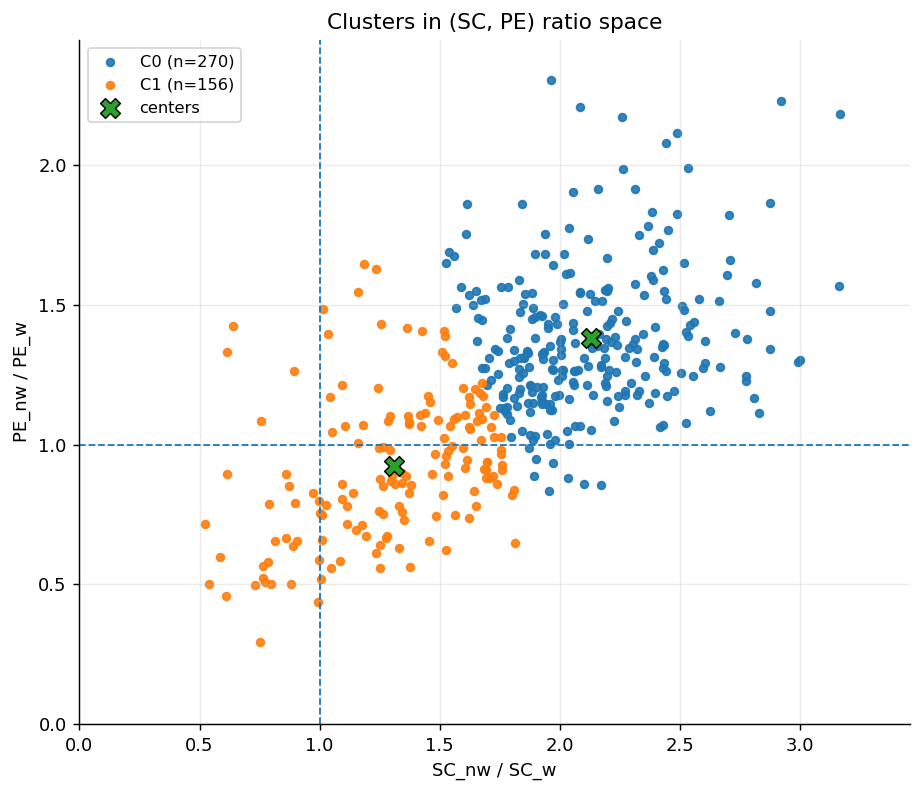

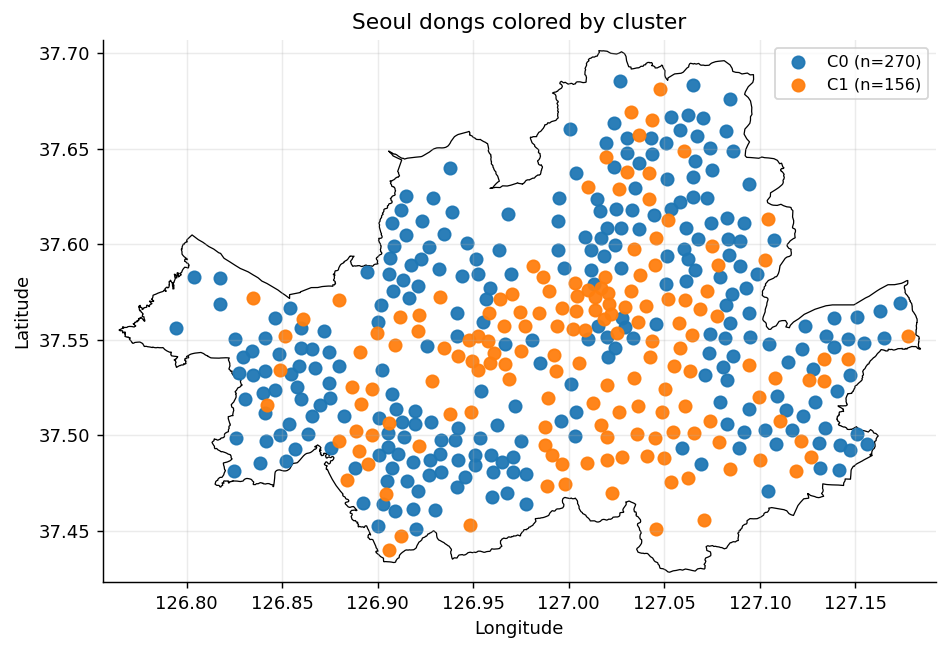

[Cell 3d] Clustering complete. K=2.
  - Cluster C0: n=270, center≈(2.131, 1.381)
  - Cluster C1: n=156, center≈(1.308, 0.923)


In [15]:
# ============================================
# Cell 3d (fixed) — Cluster dongs in (SC_nw/SC_w, PE_nw/PE_w) space
#                    and plot (A) scatter with clusters
#                          (B) Seoul map colored by cluster
#
# Inputs expected in memory:
#   - df_SC_PE with columns: ["SC_nw","SC_w","PE_nw","PE_w"]
#   - pop_ordered: population weights aligned to df_SC_PE/dong_ids
#   - dong_ids: list/array of dong codes aligned to df_SC_PE
#   - data_dir: base folder (for centroids file)
# Files:
#   - ./data/Seoul426dong_x_y.xlsx (EPSG:5179 columns: Dongcode, c1, c2)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# (0) Build the (x,y) ratios table and df_map if missing
# -------------------------------
need_build = ('df_rat' not in globals()) or ('df_map' not in globals())

if need_build:
    SC_nw = df_SC_PE["SC_nw"].to_numpy(float)
    SC_w  = df_SC_PE["SC_w" ].to_numpy(float)
    PE_nw = df_SC_PE["PE_nw"].to_numpy(float)
    PE_w  = df_SC_PE["PE_w" ].to_numpy(float)
    w_pop_all = np.asarray(pop_ordered, float)

    mask_base = (
        np.isfinite(SC_nw) & np.isfinite(SC_w) & (SC_w > 0) &
        np.isfinite(PE_nw) & np.isfinite(PE_w) & (PE_w > 0) &
        np.isfinite(w_pop_all) & (w_pop_all >= 0)
    )
    x_ratio_all = np.divide(SC_nw, SC_w, out=np.full_like(SC_nw, np.nan), where=(SC_w > 0))
    y_ratio_all = np.divide(PE_nw, PE_w, out=np.full_like(PE_w, np.nan), where=(PE_w > 0))
    mask_pos = mask_base & (x_ratio_all > 0) & (y_ratio_all > 0)

    df_rat = pd.DataFrame({
        "dong_cd": np.array(dong_ids)[mask_pos],
        "x_ratio": x_ratio_all[mask_pos],
        "y_ratio": y_ratio_all[mask_pos],
        "w_pop":   w_pop_all[mask_pos],  # present when rebuilding here
    })

    # [ADD-RAW] carry original raw fields into df_rat so later cells can export them
    df_rat["SC_nw"] = SC_nw[mask_pos].astype(float)
    df_rat["SC_w"]  = SC_w [mask_pos].astype(float)
    df_rat["PE_nw"] = PE_nw[mask_pos].astype(float)
    df_rat["PE_w"]  = PE_w [mask_pos].astype(float)

    # ---- Read centroids (EPSG:5179) and project to WGS84 ----
    cent_file = os.path.join(data_dir, "Seoul426dong_x_y.xlsx")
    df_xy = pd.read_excel(cent_file, engine="openpyxl", usecols=[0,1,2])
    df_xy.columns = ["dong_cd", "c1_raw", "c2_raw"]

    def _to_num(v):
        s = str(v).strip().replace(" ", "").replace(",", ".")
        return pd.to_numeric(s, errors="coerce")

    df_xy["c1"] = df_xy["c1_raw"].map(_to_num)
    df_xy["c2"] = df_xy["c2_raw"].map(_to_num)
    df_xy = df_xy[np.isfinite(df_xy["c1"]) & np.isfinite(df_xy["c2"])].copy()
    df_xy["dong_cd"] = df_xy["dong_cd"].astype(str)

    import geopandas as gpd
    gdf_xy = gpd.GeoDataFrame(
        df_xy,
        geometry=gpd.points_from_xy(df_xy["c1"], df_xy["c2"]),
        crs="EPSG:5179"
    ).to_crs(epsg=4326)
    df_xy["lon"] = gdf_xy.geometry.x
    df_xy["lat"] = gdf_xy.geometry.y
    df_xy = df_xy[["dong_cd","lon","lat"]]

    # Merge
    df_map = pd.merge(df_rat, df_xy, on="dong_cd", how="inner")
    df_map = df_map[np.isfinite(df_map["lon"]) & np.isfinite(df_map["lat"])].copy()
else:
    # Ensure population weights are available in df_rat even if Cell 3c created it without w_pop
    if "w_pop" not in df_rat.columns:
        # [FIX-1] Attach weights by mapping dong_ids -> pop_ordered
        pop_map = pd.Series(
            np.asarray(pop_ordered, float),
            index=pd.Index([str(d) for d in dong_ids], name="dong_cd")
        )
        df_rat = df_rat.copy()
        df_rat["w_pop"] = df_rat["dong_cd"].map(pop_map).astype(float)
        # Replace any missing/invalid weights by 1.0 to keep clustering robust
        df_rat["w_pop"] = np.where(np.isfinite(df_rat["w_pop"]) & (df_rat["w_pop"] >= 0),
                                   df_rat["w_pop"], 1.0)
        print("[Cell 3d][FIX-1] Added 'w_pop' to df_rat by mapping dong population weights.")

    # [FIX-RAW-ELSE] if raw fields are missing, merge them from df_SC_PE via dong_ids
    _missing_raw = [c for c in ["SC_nw","SC_w","PE_nw","PE_w"] if c not in df_rat.columns]
    if _missing_raw:
        raw_map = pd.DataFrame({
            "dong_cd": [str(d) for d in dong_ids],
            "SC_nw":   df_SC_PE["SC_nw"].to_numpy(float),
            "SC_w":    df_SC_PE["SC_w" ].to_numpy(float),
            "PE_nw":   df_SC_PE["PE_nw"].to_numpy(float),
            "PE_w":    df_SC_PE["PE_w" ].to_numpy(float),
        })
        df_rat = (df_rat
                  .merge(raw_map, on="dong_cd", how="left", validate="m:1"))
        print(f"[Cell 3d][FIX-RAW-ELSE] Attached raw fields from df_SC_PE → df_rat "
              f"(added: {', '.join(_missing_raw)}).")

# -------------------------------
# (1) Prepare data for clustering
# -------------------------------
X = df_rat[["x_ratio","y_ratio"]].to_numpy(dtype=float)
W = df_rat["w_pop"].to_numpy(dtype=float)   # safe now
dong_array = df_rat["dong_cd"].to_numpy(str)

if X.shape[0] < 3:
    print("[Cell 3d] Too few valid dongs for clustering.")
else:
    # -------------------------------
    # (2) K selection + clustering
    # -------------------------------
    RANDOM_STATE = 42
    K_RANGE = range(2, 7)  # 2..6 inclusive

    def _fit_kmeans_numpy(X, k, n_init=10, iters=100, random_state=RANDOM_STATE):
        rng = np.random.default_rng(random_state)
        best_inertia = np.inf
        best_labels = None
        best_centers = None
        for _ in range(n_init):
            # k-means++ init
            centers = np.empty((k, X.shape[1]), dtype=float)
            idx0 = rng.integers(0, X.shape[0])
            centers[0] = X[idx0]
            d2 = np.sum((X - centers[0])**2, axis=1)
            for j in range(1, k):
                probs = d2 / (d2.sum() + 1e-12)
                idx = rng.choice(X.shape[0], p=probs)
                centers[j] = X[idx]
                d2 = np.minimum(d2, np.sum((X - centers[j])**2, axis=1))

            # Lloyd iterations
            for _it in range(iters):
                dist2 = np.sum((X[:, None, :] - centers[None, :, :])**2, axis=2)
                labels = np.argmin(dist2, axis=1)
                new_centers = np.array([X[labels==c].mean(axis=0) if np.any(labels==c) else centers[c]
                                        for c in range(k)], dtype=float)
                if np.allclose(new_centers, centers, atol=1e-8):
                    centers = new_centers
                    break
                centers = new_centers
            dist2 = np.sum((X - centers[labels])**2, axis=1)
            inertia = dist2.sum()
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centers = centers.copy()
        return best_labels, best_centers, best_inertia

    def _knee_from_inertias(ks, inertias):
        x = np.array(list(ks), dtype=float)
        y = np.array(inertias, dtype=float)
        y = (y - y.min()) / (y.max() - y.min() + 1e-12)
        d1 = np.diff(y)
        d2 = np.diff(d1)
        if len(d2) == 0:
            return ks[0]
        knee_idx = np.argmax(np.abs(d2)) + 1
        return ks[knee_idx]

    used_sklearn = False
    labels = None
    centers = None
    chosen_k = None
    quality = {}

    try:
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score

        # Choose K by silhouette
        best_score = -1.0
        best_k = None
        best_model = None
        for k in K_RANGE:
            # [FIX-2] Set explicit n_init (compat with older/newer sklearn)
            km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)  # [FIX-2]
            km.fit(X)  # sample_weight not universally supported across versions
            lab = km.labels_
            if len(np.unique(lab)) < 2:
                continue
            score = silhouette_score(X, lab)
            quality[k] = float(score)
            if score > best_score:
                best_score = score
                best_k = k
                best_model = km
        if best_model is None:
            best_model = KMeans(n_clusters=2, n_init=20, random_state=RANDOM_STATE).fit(X)  # [FIX-2]
            best_k = 2
            quality[2] = np.nan
        labels = best_model.labels_.astype(int)
        centers = best_model.cluster_centers_
        chosen_k = int(best_k)
        used_sklearn = True
        print(f"[Cell 3d] sklearn KMeans selected K={chosen_k} via silhouette (scores: {quality}).")
    except Exception as e:
        print(f"[Cell 3d][INFO] scikit-learn unavailable or failed ({e}). Falling back to NumPy k-means + elbow.")
        inertias = {}
        labels_k = {}
        centers_k = {}
        for k in K_RANGE:
            lab_k, ctr_k, iner_k = _fit_kmeans_numpy(X, k, n_init=10, iters=100, random_state=RANDOM_STATE)
            inertias[k] = float(iner_k)
            labels_k[k] = lab_k
            centers_k[k] = ctr_k
        chosen_k = _knee_from_inertias(list(K_RANGE), [inertias[k] for k in K_RANGE])
        labels = labels_k[chosen_k]
        centers = centers_k[chosen_k]
        print(f"[Cell 3d] NumPy k-means selected K={chosen_k} (elbow on inertia={inertias}).")

    # -------------------------------
    # (3) Attach cluster labels to tables
    # -------------------------------
    df_rat = df_rat.copy()
    df_rat["cluster"] = labels
    df_map = pd.merge(
        df_map.drop(columns=[c for c in ["cluster"] if c in df_map.columns]),
        df_rat[["dong_cd","cluster"]],
        on="dong_cd", how="left"
    )

    # -------------------------------
    # (4) Plots
    # -------------------------------
    import matplotlib as mpl
    tab = mpl.colormaps.get_cmap("tab10")
    clrs = [tab(i % 10) for i in range(int(chosen_k))]
    cluster_names = [f"C{c}" for c in range(int(chosen_k))]

    # (A) Scatter in ratio space
    figA, axA = plt.subplots(figsize=(7.2, 6.2))
    axA.axvline(1.0, linestyle="--", linewidth=1.0)
    axA.axhline(1.0, linestyle="--", linewidth=1.0)
    for c in range(chosen_k):
        msk = (labels == c)
        if not np.any(msk):
            continue
        axA.scatter(
            X[msk,0], X[msk,1],
            s=18, alpha=0.9, label=f"{cluster_names[c]} (n={msk.sum()})",
        )
    axA.scatter(centers[:,0], centers[:,1], s=120, marker="X", edgecolors="k", linewidths=0.8, label="centers")
    # bounds
    qx = float(np.nanquantile(X[:,0], 0.995)); qy = float(np.nanquantile(X[:,1], 0.995))
    xmax = min(5.0, max(2.0, 1.10*qx)); ymax = min(5.0, max(2.0, 1.10*qy))
    axA.set_xlim(0, xmax); axA.set_ylim(0, ymax)
    axA.set_xlabel("SC_nw / SC_w"); axA.set_ylabel("PE_nw / PE_w")
    axA.set_title("Clusters in (SC, PE) ratio space")
    axA.legend(loc="best", fontsize=9, frameon=True)
    try: plt.tight_layout()
    except Exception: pass
    plt.show()

    # (B) Seoul map with centroids colored by cluster
    use_plain_scatter = False
    seoul_geom = None
    try:
        import osmnx as ox
        ox.settings.log_console = False
        gdf_city = ox.geocode_to_gdf("Seoul, South Korea")
        if (gdf_city is not None) and (len(gdf_city) > 0):
            seoul_geom = gdf_city.to_crs(epsg=4326)
        else:
            use_plain_scatter = True
    except Exception as e:
        print(f"[Cell 3d][INFO] OSMnx not available or geocoding failed ({e}). Using plain scatter.")
        use_plain_scatter = True

    figB, axB = plt.subplots(figsize=(7.4, 7.0))
    if not use_plain_scatter and seoul_geom is not None:
        seoul_geom.plot(ax=axB, facecolor="white", edgecolor="black", linewidth=0.7)
        minx, miny, maxx, maxy = seoul_geom.total_bounds
    else:
        minx, maxx = df_map["lon"].min(), df_map["lon"].max()
        miny, maxy = df_map["lat"].min(), df_map["lat"].max()

    for c in range(chosen_k):
        sub = df_map[df_map["cluster"] == c]
        if sub.empty:
            continue
        axB.scatter(
            sub["lon"].values, sub["lat"].values,
            s=46, alpha=0.95, label=f"{cluster_names[c]} (n={len(sub)})"
        )

    pad_x = (maxx - minx) * 0.02; pad_y = (maxy - miny) * 0.02
    axB.set_xlim(minx - pad_x, maxx + pad_x)
    axB.set_ylim(miny - pad_y, maxy + pad_y)
    axB.set_aspect("equal", adjustable="box")
    axB.set_xlabel("Longitude"); axB.set_ylabel("Latitude")
    axB.set_title("Seoul dongs colored by cluster")
    axB.legend(loc="best", fontsize=9, frameon=True)
    try: plt.tight_layout()
    except Exception: pass
    plt.show()

    # -------------------------------
    # (5) Summary prints
    # -------------------------------
    counts = df_rat["cluster"].value_counts().sort_index()
    print(f"[Cell 3d] Clustering complete. K={chosen_k}.")
    for c in range(chosen_k):
        n_c = int(counts.get(c, 0))
        cx, cy = centers[c]
        print(f"  - Cluster C{c}: n={n_c:3d}, center≈({cx:.3f}, {cy:.3f})")


# ----------------- end of code ---------------------